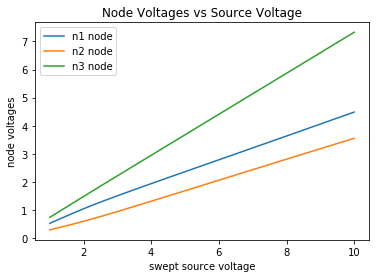

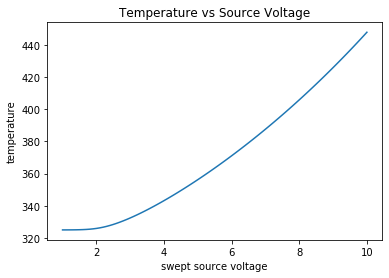

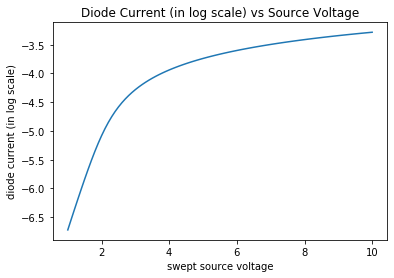

In [1]:
################################################################################
# HW6 Diode Temperature                                                        #
# Steve Millman based on Hartin & Allee                                        #
################################################################################

import numpy as np                  # import required packages
from scipy import optimize
import matplotlib.pyplot as plt

################################################################################
# Define required constants                                                    #
################################################################################

MIL = 25               # conversion factor
UM2CM = 1e-4           # square centimeters in meters
LAYERS = 5             # number of layers

# Debug flag
display_graph = True
display_counter = False
display_values = False

# Thermal Coefficients W/cmC - these are the layers we need to solve!
#   0  Si active        8 mil  1.3
#   1  Si bulk         12 mil  1.3
#   2  Cu back metal   7 mil   3.86
#   3  paste           30 mil  0.5
#   4  Metal flag      120 mil 5
K = np.array([1.3,1.3,3.86,0.5,5.0],float)

# thickness of each layer in cm
THICK = np.array([8,12,7,30,120],float) * MIL * UM2CM

# Diode Constants
I0   = 3e-9                 # reverse bias saturation current
Q    = 1.6e-19              # charge on the electron
KB   = 1.38e-23             # Boltzmann constant
IDE  = 2.0                  # Ideality factor
AREA = 10*UM2CM*10*UM2CM;   # Area of the diode

MAX_SOURCE_V = 10           # Maximum source voltage to analyze
MIN_SOURCE_V =  1           # Minimum source voltage to analyze
V_STEP = 0.1                # Voltage step size
R1 = 2e3                    # values of the various resistors
R2 = 5e3
R3 = 3e3
R4 = 2e3
R5 = 1e3
TBASE = 325                 # Constant temperature of the base

################################################################################
# Solve for pseudo 2D self heating based on stack. Start at the base layer     #
# which is at a constant temperature. Then work our way up.                    #
# Inputs:                                                                      #
#    current -    current through the structure                                #
#    voltage -    voltage across the structure                                 #
#    tbase   -    temperatue of the bottom layer                               #
# Outputs:                                                                     #
#    temp    -    temperature of the top layer                                 #
################################################################################

def calc_temp(current,voltage,tbase):

    heat_flow = current * voltage
    thermal_resistance = THICK / (K * AREA)
    t_top = tbase + sum(heat_flow * thermal_resistance)
    #print(len(tbase))


    return t_top

################################################################################
# Return diode current and temperature error                                   #
# Inputs:                                                                      #
#    volt     - voltage across the device                                      #
#    tguess   - guess at device temperature                                    #
#    tbase    - temperature of the bottom layer                                #
# Outputs:                                                                     #
#    curr     - current through the diode                                      #
#    t_err    - difference between the guess and the calculated value          #
################################################################################

def diode_i_terr(volt,tguess,tbase):

    d_curr = I0 * (np.exp((Q * volt) / (IDE * KB * tguess)) -1)
    t_calc = calc_temp(d_curr, volt, tbase)

    return( d_curr, t_calc-tguess )

################################################################################
# Bridge with a diode with node and temperature error. Based on the guess of   #
# voltages, compute diode current and temp error. Then compute the current at  #
# each node, which should sum to 0. Return these sums and the temp error.      #
# Inputs:                                                                      #
#    parmams - an array containing the following values fsolve will optimize:  #
#              index 0 - the voltage at node 1                                 #
#              index 1 - the voltage at node 2                                 #
#              index 2 - the voltage at node 3                                 #
#              index 3 - the temperature of the diode                          #
#    source_v - the source voltage                                             #
#    tbase    - the temperate of the base layer                                #
# Outputs:                                                                     #
#    An array of the sum of the currents at each node plus the temperature err #
################################################################################

#Counter the number of iterations for debugging
counter=0

def f(params,source_v,tbase):
    n1_v   = params[0]       # extract the parameters
    n2_v   = params[1]
    n3_v   = params[2]
    tguess = params[3]

    if(display_counter):
        global counter
        counter = counter + 1
        print("Counter: " + str(counter))

    # compute the diode current and temperature
    diode_current, diode_temp_err  = diode_i_terr(n1_v - n2_v, tguess, tbase)

    # based on the calculated current and received voltages, sum the currents
    # at each node
    n1_i = ((n1_v - n3_v) / R1) + (n1_v / R2) + diode_current
    n2_i = ((n2_v - n3_v) / R3) + (n2_v / R4) - diode_current
    n3_i = ((source_v - n3_v) / R5) + ((n1_v - n3_v) / R1) + ((n2_v - n3_v) / R3)

    return([n1_i,n2_i,n3_i,diode_temp_err])  # goal is all values to be 0!

def diode_i(volt,tguess):

    d_curr = I0 * (np.exp((Q * volt) / (IDE * KB * tguess)) -1)
    return d_curr

################################################################################
# This is the main loop. We create arrays to hold the data for each value of   #
# the voltage source. Then we execute the loop for each source voltage.        #
################################################################################

source_vals = np.arange(MIN_SOURCE_V,MAX_SOURCE_V+V_STEP,V_STEP) # Vs to use
n1_vals = np.zeros_like(source_vals)              # node 1 voltages
n2_vals = np.zeros_like(source_vals)              # node 2 voltages
n3_vals = np.zeros_like(source_vals)              # node 3 voltages
t_vals  = np.zeros_like(source_vals)              # temperature values
i_vals  = np.zeros_like(source_vals)              # diode current values

temp = TBASE          # initial guesses
v1 = MIN_SOURCE_V     # after first value, we use the last calculated as the
v2 = MIN_SOURCE_V     # initial values
v3 = MAX_SOURCE_V 

# This loop estimates the values of the node voltages, temperature across the diode and
# diode current by minimizing the error current flow according to Kirchoff's
# current law and reducing the temperature error
for index in range(len(source_vals)):
    [v1,v2,v3,temp] = optimize.fsolve(f,[v1,v2,v3,temp],(source_vals[index],TBASE))
    n1_vals[index] = v1
    n2_vals[index] = v2
    n3_vals[index] = v3
    t_vals[index] = temp
    i_vals[index] = diode_i(v1 - v2, temp)

# Print out the values for n1, n2, n3 voltages and diode current and temperature
if(display_values):
    print("\nNode 1 voltages: \n" + str(n1_vals))
    print("\nNode 2 voltages: \n" + str(n2_vals))
    print("\nNode 3 voltages: \n" + str(n3_vals))
    print("\nDiode current: \n" + str(i_vals))
    print("\nTemperature: \n" + str(t_vals))

if(display_graph):

    # Generate plot for node 1 voltages across the sweep of source
    # voltages
    plt.plot(source_vals, n1_vals, label = 'n1 node')
    plt.ylabel("node voltages")
    plt.xlabel("swept source voltage")
    plt.title("Node 1 Voltage vs Source Voltage")

    # Generate plot for node 1 voltages across the sweep of source
    # voltages
    plt.plot(source_vals, n2_vals, label='n2 node')
    plt.xlabel("swept source voltage")
    plt.title("Node 2 Voltage vs Source Voltage")

    # Generate plot for node 1 voltages across the sweep of source
    # voltages
    plt.plot(source_vals, n3_vals, label = 'n3 node')
    plt.xlabel("swept source voltage")
    plt.title("Node Voltages vs Source Voltage")
    plt.legend()
    plt.show()

    # Generate plot for tempertaure values across the sweep of source
    # voltages
    plt.plot(source_vals, t_vals)
    plt.ylabel("temperature")
    plt.xlabel("swept source voltage")
    plt.title("Temperature vs Source Voltage")
    plt.show()

    # Generate plot for current values (in log) across the sweep of source
    # voltages
    plt.plot(source_vals, np.log10(i_vals))
    plt.ylabel("diode current (in log scale)")
    plt.xlabel("swept source voltage")
    plt.title("Diode Current (in log scale) vs Source Voltage")
    plt.show()